# IndiaSim Graph-Style ABM Model Prototype

In [1]:
#import Pkg # for installing packages/package manager
## get packages that are necessary or install them if they don't exist in the current environment
#Pkg.add(["Agents", "Random", "DataFrames", "LightGraphs", "Distributions", "DrWatson", "Plots","StatsBase"])

In [1]:
using Agents, Random, DataFrames, LightGraphs
using Distributions: Poisson, DiscreteNonParametric,Uniform
using DrWatson: @dict
using Plots
using StatsBase: sample

In [2]:
# may be good to upgrade this with the specific syntax
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent 
    id::Int
    pos::Int
    days_infected::Int  # number of days since is infected
    status::Symbol
    infection_period::Int 
    transmission::Array{Float64,1} #I added agent-level tranmission, simpler to have this as an array,
#and compute days_infected upon infection, and transmission rate array for each of the the days infected.
    death_probs::Array{Float64,1} #Death probability has same framework as transmissions
    reinfection_probability::Float64
    vaccine_efficacy::Float64 #Probability for successfully transmitted disease to infect the agent is 1-vaccine_efficacy
    
    # let's add in SAGE-W
    # state::Symbol
    age_cat::Int
    # gender::Symbol
    # education::Int
    # wealth::Int
    # room for adding in whatever else later
end

In [3]:
# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    N_total, 
    contact_matrix,
    baseline_transmission_distribution,
    baseline_death_distribution,
    infect_period_distribution,
    reinfection_distribution,
    vaccine_efficacy_distribution,
    transmission_scale_up_down, #Scale transmission rate by # days infected
    # awesome! let's just make sure this is parametrized with the right data
    death_scale_up_down, #Scale death probability by # days infected
    proportion_vaccinate,
    killed_agents,
    unvaccinated,#Array of ids of unvaccinated agents
    prevalence_disease, #Approximate proportion of agents infected at onset
    seed = 108,
)

    rng = MersenneTwister(seed)
    # normalize migration_rates
    contact_matrix_sum = sum(contact_matrix, dims = 2)
    for c in 1:80
        contact_matrix[c, :] ./= contact_matrix_sum[c]
    end
    
    #Precomputing age categories so that interaction_matrix can be part of class
    ages = rand(1:80,N_total)
    
    interaction_matrix = zeros(N_total, N_total)
    for i in 1:N_total
        # wonder if there's a clever way to do this that cuts out one for loop by
        for j in 1:N_total
            interaction_matrix[i, j] = contact_matrix[ages[i],ages[j]]
        end
    end
    
    unvaccinated = [i for i in 1:N_total]
    
    
    properties = @dict(
    N_total,
    contact_matrix,
    baseline_transmission_distribution,
    baseline_death_distribution,
    infect_period_distribution,
    reinfection_distribution,
    vaccine_efficacy_distribution,
    transmission_scale_up_down, #vector of 2 proportion values. value 1: proportion of first days of infection in which transmission rate builds up
        #value 2: proportion of last days of infection in which transmission rate drops
    death_scale_up_down, #same concept as 'transmission_scale_up_down': determines proportion of days of infection in which
        #death probability increases and drops.
    proportion_vaccinate,
    killed_agents,
    interaction_matrix,
    unvaccinated, #This array will contain the ids of agents who have not been vaccinated (so we can keep track)
    prevalence_disease
    )
    # wonder if there's a clever way to do what we do below with the interaction_matrix by using a SimpleWeightedDiGraph
    # and baking in the weights
    space = GraphSpace(complete_digraph(N_total)) # everyone connected to everyone else
    model = ABM(PoorSoul, space; properties, rng)

    # Add initial individuals
    prevalence_disease = 0.2 #Let's remember to add variation to this value for each district.
    index=1
    for n in 1:N_total
        
        #introduce variation of infection period on a per-agent basis
        infection_period = infect_period_distribution() 
        
        
        reinfection_prob = reinfection_distribution()
        if rand(rng) <= prevalence_disease    
                
            #This is individual's baseline transmission sampled from a distribution,
                #we can adjust to sample from a gamma distribution when we have the data
            infectiousness = baseline_transmission_distribution()
            
            death_probability = baseline_death_distribution()
            
            #Below we introduce individual-specific transmission scaled by  day of the infection period
            trans_scale_up_days = trunc(Int,round(infection_period*transmission_scale_up_down[1])) #How many days we scale up transmission until maximum value
            trans_scale_down_days=trunc(Int,round(infection_period*transmission_scale_up_down[2])) #How many days we scale down transmission until 0
            
            if trans_scale_up_days <2 #if less than 2 days, the LinRange function throws an exception
                if trans_scale_up_days==1
                    trans_scale_increasing=[0]
                else
                    trans_scale_increasing=[]
                end
            else
                trans_scale_increasing = LinRange(0, 1, trans_scale_up_days)
                
            end
            
            if trans_scale_down_days <2
                if trans_scale_down_days==1
                    trans_scale_decreasing=[0]
                else
                    trans_scale_decreasing=[]
                end
            else
                trans_scale_decreasing = LinRange(1, 0, trans_scale_down_days) 
            end        
            
            
            tranmission_scale_by_day=vcat(trans_scale_increasing,
                ones(infection_period-trans_scale_up_days-trans_scale_down_days),trans_scale_decreasing)
            
            death_scale_up_days = trunc(Int,round(infection_period*death_scale_up_down[1])) #How many days we scale up death probability until maximum value
            death_scale_down_days=trunc(Int,round(infection_period*death_scale_up_down[2])) #How many days we scale down death probability until 0
            
            
            if death_scale_up_days <2 #if less than 2 days, the LinRange function throws an exception
                if death_scale_up_days==1
                    death_scale_increasing=[0]
                else
                    death_scale_increasing=[]
                end
            else
                death_scale_increasing = LinRange(0, 1, death_scale_up_days)
                
            end
            
            if death_scale_down_days <2
                if death_scale_down_days==1
                    death_scale_decreasing=[0]
                else
                    death_scale_decreasing=[]
                end
            else
                death_scale_decreasing = LinRange(1, 0, death_scale_down_days) 
            end        
            
            
            death_scale_by_day=vcat(death_scale_increasing,
                ones(infection_period-death_scale_up_days-death_scale_down_days),death_scale_decreasing)
            
            #Below, we add daily variation to the agent's baseline transmission (random uniform) to account for differences in individual interaction by day
            ind = add_agent!(n,model,1,:I,infection_period,rand(Uniform(0,infectiousness),infection_period).*tranmission_scale_by_day,
                [death_probability for i in 1:infection_period].*death_scale_by_day,reinfection_prob,0,ages[index])
            #ind = add_agent!(n, model, 0, :I, rand(1:80)) # ages and gender whatnot should be pulled from nfhs data
        else
            ind = add_agent!(n,model,0,:S, infection_period,Float64[],Float64[],reinfection_prob,0,ages[index])
        end
        index+=1

    end
    
    return model
end

model_initiation (generic function with 1 method)

In [4]:
using LinearAlgebra: diagind


#Next five functions are the distributions of transmission rate, death probability, infection period, reinfection
    #probability, and vaccine efficacy for agent sampling

#Can adjust 'trans_dist' to sample from gamma distribution to model superspreaders 
function trans_dist(lower=0,upper=0.4)
    return rand(Uniform(lower,upper))
    end


function death_dist(lower=0,upper=0.01)
    return rand(Uniform(lower,upper))
    end

function infect_period_dist(lower=5,upper=30)
    return rand(lower:upper)
    end

function reinfection_dist(lower=0,upper=0.05)
    return rand(Uniform(lower,upper))
end

function vaccine_efficacy_dist(lower=0.6,upper=1.0)
    return rand(Uniform(lower,upper))
end

function create_params(;
    N_total, # is the number of agents
    baseline_transmission_distribution=trans_dist,#Distribution of individual baseline transmission probabilities
    baseline_death_distribution=death_dist, #Distribution of individual death probability
    infect_period_distribution=infect_period_dist, #Distribution of individual infection_periods
    reinfection_distribution=reinfection_dist, #Distribution of reinfection probabilities
    vaccine_efficacy_distribution = vaccine_efficacy_dist, #Distribution of vaccine efficacy on agent basis
    transmission_scale_up_down= [0.25,0.25], #proportion of the days of infection_period in which tranmission rate increases, decreases
    death_scale_up_down =[0.25,0.25], #proportion of the days of infection_period in which death probability increases, decreases
    proportion_vaccinate = 0.02, #proportion of unvaccinated agents that get vaccinated each step
    prevalence_disease=0.2, #the approximate proportion of infected agents infected at onset of disease
    seed = 108,
        
)


    Random.seed!(seed)
    contact_matrix = zeros(80, 80)
    for c in 1:80
        for c2 in 1:80
            contact_matrix[c, c2] = rand()
        end
    end
    maxM = maximum(contact_matrix)
    contact_matrix = (contact_matrix) ./ maxM
    contact_matrix[diagind(contact_matrix)] .= 1.0
    killed_agents = Vector{Float64}()
    unvaccinated = Array{Int,1}()

    params = @dict(
        N_total,
        contact_matrix,
        baseline_transmission_distribution,
        baseline_death_distribution,
        infect_period_distribution,
        reinfection_distribution,
        vaccine_efficacy_distribution,
        transmission_scale_up_down,
        death_scale_up_down,   
        proportion_vaccinate,
        unvaccinated,
        prevalence_disease,
        killed_agents)

    return params
end

params = create_params(N_total = 1000)
model = model_initiation(; params...)

AgentBasedModel with 1000 agents of type PoorSoul
 space: GraphSpace with 1000 positions and 999000 edges
 scheduler: fastest
 properties: interaction_matrix, N_total, killed_agents, infect_period_distribution, baseline_transmission_distribution, proportion_vaccinate, unvaccinated, reinfection_distribution, contact_matrix, death_scale_up_down, vaccine_efficacy_distribution, prevalence_disease, transmission_scale_up_down, baseline_death_distribution

In [5]:
function model_step!(model)
   vaccinate!(model) 
end

function agent_step!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
end


function vaccinate!(model) #assign random agents to get vaccinated
    
    number_agents_to_vaccinate = trunc(Int,round(model.proportion_vaccinate*length(model.unvaccinated)))
    #println("how many can vaccinate:",length(model.unvaccinated))
    #println("how many to vaccinate:",number_agents_to_vaccinate)
    #println("unvaccinated:",model.unvaccinated)
    ids_agents_vaccinate = sample(model.unvaccinated,number_agents_to_vaccinate,replace=false)
    
    for n in ids_agents_vaccinate
        model[n].vaccine_efficacy = vaccine_efficacy_dist()
        deleteat!(model.unvaccinated, model.unvaccinated .== n)  
    end     
end


function transmit!(agent, model)
    agent.status != :I && return
    rate = agent.transmission[agent.days_infected]

    # this follows the outline suggested in the lloyd-smith paper, though I prefer an NB  distribution
    # hard part is to quantify the superspreading parameter, though....
    
    #^^Chirag, We can just adjust the trans_dist function to account for superspreaders (sample from gamma distribution);
        #"transmission" will have to be >>1 
    
        # yep! you're right -- we just need to get the superspreading parameter
        # which we can get from the contact matrix paper
        # i have a way of doing this -- let me think about a clever way of making sure it's all self consistent, though....
        # i can implement our we can discuss on our call
    d = Poisson(rate)
    n = rand(model.rng, d)
    #println("#infected:",n)
    n == 0 && return 

    
    # pick a random agent in the network and infect them
    pid = agent.pos
    # effectively a function that pulls a new spot for the agent to travel to with probabilities given by the contact matrix
    d = DiscreteNonParametric(1:(model.N_total), model.interaction_matrix[pid, :] ./ sum(model.interaction_matrix[pid, :]))
    for i in 0:n
        m = rand(model.rng, d)
        if m ≠ pid && !(m in model.killed_agents)
                    #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[m].status == :S && rand(model.rng) <= 1-model[m].vaccine_efficacy) || (model[m].status == :R && rand(model.rng) ≤ model[m].reinfection_probability && rand(model.rng) <= 1-model[m].vaccine_efficacy)
                model[m].status = :I
                
                # Next lines below we are computing the individual transmission/death probability by day for the duration of
                    #infection_period
                
                infectiousness = model.baseline_transmission_distribution()
                
                death_probability = model.baseline_death_distribution()
                        
                #Below we introduce individual-specific transmission scaled by day of the infection period
                trans_scale_up_days = trunc(Int,round(model[m].infection_period*model.transmission_scale_up_down[1])) #How many days we scale up transmission until maximum value
                trans_scale_down_days=trunc(Int,round(model[m].infection_period*model.transmission_scale_up_down[2])) #How many days we scale down transmission until 0
                
                if trans_scale_up_days <2 #if less than 2 days, the LinRange function throws an exception
                    if trans_scale_up_days==1
                        trans_scale_increasing=[0]
                    else
                        trans_scale_increasing=[]
                    end
                else
                    trans_scale_increasing = LinRange(0, 1, trans_scale_up_days)
                    
                end
                
                if trans_scale_down_days <2
                    if trans_scale_down_days==1
                        trans_scale_decreasing=[0]
                    else
                        trans_scale_decreasing=[]
                    end
                else
                    trans_scale_decreasing = LinRange(1, 0, trans_scale_down_days) 
                end        
                
                
                tranmission_scale_by_day=vcat(trans_scale_increasing,
                    ones(model[m].infection_period-trans_scale_up_days-trans_scale_down_days),trans_scale_decreasing)
                
                death_scale_up_days = trunc(Int,round(model[m].infection_period*model.death_scale_up_down[1])) #How many days we scale up death probability until maximum value
                death_scale_down_days=trunc(Int,round(model[m].infection_period*model.death_scale_up_down[2])) #How many days we scale down death probability until 0
                
                
                if death_scale_up_days <2 #if less than 2 days, the LinRange function throws an exception
                    if death_scale_up_days==1
                        death_scale_increasing=[0]
                    else
                        death_scale_increasing=[]
                    end
                else
                    death_scale_increasing = LinRange(0, 1, death_scale_up_days)
                    
                end
                
                if death_scale_down_days <2
                    if death_scale_down_days==1
                        death_scale_decreasing=[0]
                    else
                        death_scale_decreasing=[]
                    end
                else
                    death_scale_decreasing = LinRange(1, 0, death_scale_down_days) 
                end        
                
                
                death_scale_by_day=vcat(death_scale_increasing,
                    ones(model[m].infection_period-death_scale_up_days-death_scale_down_days),death_scale_decreasing)
                
                #We add daily variation to the agent's baseline transmission (random uniform) to account for differences in individual interaction by day
                
                # eek -- ok, fine, this is the right idea. but i am very uncomfortable with this way of doing it. we can't just vary these things uniformly -- that's not at all biologically relevent
                # however, you raise a good point that finding this kind of data is challenging
                # so what i am comfortable with is the following: either parametrizing based on tb data (because tb is also a bacterial respiratory infection), or coming up with some
                # very simple linear system and then using a massive CI and simulating data from that
                # but the key thing here is that the transmission probability increases monotonically till the peak and then decreases monotonically
                # i have an idea of how to do this -- we can talk about it on Wednesday or I can implement it efore then if you'd like

                model[m].transmission=rand(Uniform(0,infectiousness),model[m].infection_period).*tranmission_scale_by_day
                
                model[m].death_probs=[death_probability for i in 1:model[m].infection_period].*death_scale_by_day

                model[m].days_infected = 1
            end
        end
    end

    # for contactID in ids_in_position(agent, model)
    #     contact = model[contactID]
    #     if contact.status == :S ||
    #        (contact.status == :R && rand(model.rng) ≤ model.reinfection_probability)
    #         contact.status = :I
    #         n -= 1
    #         n == 0 && return
    #     end
    # end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)

    
    # NOTE! Can only apply the CFR if we ask ONCE whether the agent dies or not.... we happen to do this at end of infection period
   
    #People will not necessarily die at only the end of infection period,
        #below code accounts for  probability of mortality at every day infected.
    agent.status!=:I && return
    if agent.days_infected==agent.infection_period
        agent.status = :R
        agent.days_infected = 0
    else
        if rand(model.rng) ≤ agent.death_probs[agent.days_infected] 
            push!(model.killed_agents, agent.id)
            kill_agent!(agent, model)
            if agent.id in model.unvaccinated #Remove the agent from unvaccinated array if agent was not vaccinated, since it
                #is now out of the picture
                deleteat!(model.unvaccinated, model.unvaccinated .== agent.id)
            end
            #println("Agent Died")
        end
    end
    
end

recover_or_die! (generic function with 1 method)

In [6]:
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

In [7]:
model = model_initiation(; params...)

to_collect = [(:status, f) for f in (infected, recovered, length)]
data, _ = run!(model, agent_step!,model_step!,100; adata = to_collect)
print(data[1:10, :],data[90:100, :])

10×4 DataFrame
 Row │ step   infected_status  recovered_status  length_status 
     │ Int64  Int64            Int64             Int64         
─────┼─────────────────────────────────────────────────────────
   1 │     0              214                 0           1000
   2 │     1              214                 0           1000
   3 │     2              223                 0            999
   4 │     3              247                 0            997
   5 │     4              261                 7            996
   6 │     5              273                11            996
   7 │     6              296                19            996
   8 │     7              305                33            993
   9 │     8              317                41            992
  10 │     9              340                48            99211×4 DataFrame
 Row │ step   infected_status  recovered_status  length_status 
     │ Int64  Int64            Int64             Int64         
─────┼───────────────

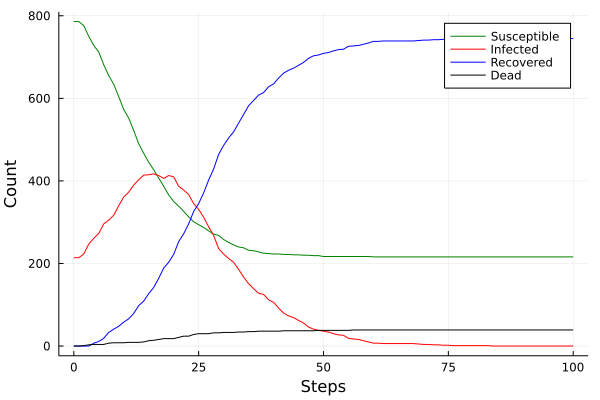

In [8]:
N = sum(model.N_total) # Total initial population
x = data.step
Plots.plot(x, (data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)]), color = :green,label="Susceptible",xlabel="Steps",ylabel="Count")
Plots.plot!(x, (data[:, aggname(:status, infected)]), color = :red,label="Infected")
Plots.plot!(x, (data[:, aggname(:status, recovered)]), color = :blue,label="Recovered")
Plots.plot!(x, (N .- data[:, aggname(:status, length)]), color = :black,label="Dead")